In [2]:
from main import *

/home/amintehrani/.pyenv/versions/3.12.8/envs/torchgeo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/amintehrani/explainable-graphst/venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/amintehrani/explainable-graphst/venv/lib/python3.12/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)


In [ ]:
torch.cuda.empty_cache()
import multiprocessing as mp
mp.set_start_method("fork", force=True)  # Only once per program

print(device)

adata = load_dataset_V1_Human_Lymph_Node()
annotate_graphclusters_V1_Human_Lymph_Node(adata)

gst = get_graphst(adata)

# path=input("Load graphST? Enter the path or N for training. Leave empty to use default path: graphst_base_encoder.pt\n")
path=""
if path == "N":
    train_graphst(gst)
    if save_path:=input("Save graphST? Enter the path or N for no saving. Leave empty to use default path: graphst_base_encoder.pt\n") != "N":
        if save_path:
            save_graphst_base_encoder(gst, save_path)
        else:
            save_graphst_base_encoder(gst)

    base_encoder = gst.model.base_encoder
else:
    if path:
        base_encoder = load_graphst_base_encoder(gst,path).to(device)
    else:
        base_encoder = load_graphst_base_encoder(gst).to(device)
    
# apply_clustering(graphst.gadata, method="leiden", n_clusters=7)

from distilled_decoder import DistilledDecoder, ClusterPredictor

decoder = DistilledDecoder(gst.dim_output, gst.adata.obs['graphclust'].nunique()).to(device)
# decoder.fit(gst, base_encoder, epochs=1000, lr=0.01, val_ratio=0.2, eval_frequency=10)
decoder.load_state_dict(torch.load("best_distilled_decoder.pt"))


cluster_predictor = ClusterPredictor(base_encoder, decoder).to(device)

torch.cuda.empty_cache()

from torch_geometric.utils import dense_to_sparse
edge_index, _ = dense_to_sparse(gst.adj)

cluster_explainer1 = Explainer(
    model=cluster_predictor,
    algorithm=GNNExplainer(epochs=100),
    explanation_type='phenomenon',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

clusters = torch.argmax(cluster_predictor(gst.features, edge_index), dim=1)
cpu = torch.device('cpu')

# cluster_explainer2 = Explainer(
#     model=cluster_predictor,
#     algorithm=GNNExplainer(epochs=250),
#     explanation_type='phenomenon',
#     node_mask_type='attributes',
#     edge_mask_type='object',
#     model_config=dict(
#         mode='multiclass_classification',
#         task_level='node',
#         return_type='log_probs',
#     ),
# )
# cluster_explainer3 = Explainer(
#     model=cluster_predictor,
#     algorithm=GNNExplainer(epochs=500),
#     explanation_type='phenomenon',
#     node_mask_type='attributes',
#     edge_mask_type='object',
#     model_config=dict(
#         mode='multiclass_classification',
#         task_level='node',
#         return_type='log_probs',
#     ),
# )
# cluster_explainer4 = Explainer(
#     model=cluster_predictor,
#     algorithm=GNNExplainer(epochs=1000),
#     explanation_type='phenomenon',
#     node_mask_type='attributes',
#     edge_mask_type='object',
#     model_config=dict(
#         mode='multiclass_classification',
#         task_level='node',
#         return_type='log_probs',
#     ),
# )
# cluster_explainer5 = Explainer(
#     model=cluster_predictor,
#     algorithm=GNNExplainer(epochs=2000),
#     explanation_type='phenomenon',
#     node_mask_type='attributes',
#     edge_mask_type='object',
#     model_config=dict(
#         mode='multiclass_classification',
#         task_level='node',
#         return_type='log_probs',
#     ),
# )

# torch.cuda.empty_cache()
# res1 = cluster_explainer1(gst.features, edge_index, target=clusters, epochs=100).to(cpu)
# res2 = cluster_explainer2(gst.features, edge_index, target=clusters.to(cpu))
# res3 = cluster_explainer3(gst.features, edge_index, target=clusters).to(cpu)
# res4 = cluster_explainer4(gst.features, edge_index, target=clusters).to(cpu)
# res5 = cluster_explainer5(gst.features, edge_index, target=clusters).to(cpu)


cuda


/home/amintehrani/explainable-graphst/venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/amintehrani/explainable-graphst/venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/amintehrani/explainable-graphst/venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:

def explain(epochs):
    cluster_explainer = Explainer(
    model=cluster_predictor,
    algorithm=GNNExplainer(epochs=epochs),
    explanation_type='phenomenon',
    node_mask_type='attributes',
    edge_mask_type='object',
        model_config=dict(
            mode='multiclass_classification',
            task_level='node',
            return_type='log_probs',
        ),
    )
    return cluster_explainer(gst.features, edge_index, target=clusters).to(cpu)

In [43]:

def explain_cluster_model(epochs):
    cluster_explainer = Explainer(
    model=cluster_predictor,
    algorithm=GNNExplainer(epochs=epochs),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
        model_config=dict(
            mode='multiclass_classification',
            task_level='node',
            return_type='log_probs',
        ),
    )
    return cluster_explainer(gst.features, edge_index, target=clusters).to(cpu)

In [44]:
res_cluster_model_250 = explain_cluster_model(250) 

/home/amintehrani/.pyenv/versions/3.12.8/envs/torchgeo/lib/python3.12/site-packages/torch_geometric/explain/explainer.py:193: UserWarning: The 'target' should not be provided for the explanation type 'model'
  warnings.warn(


tensor([0.0000, 0.0000, 0.1668,  ..., 0.2416, 0.1696, 0.2319])

In [8]:
res2 = explain(250)

In [9]:
res3 = explain(500)

In [10]:
res4 = explain(1000)

In [11]:
res5 = explain(2500)

In [12]:
import matplotlib.pyplot as plt

In [56]:
torch.where(clusters == 2)

(tensor([   5,    6,   21,   25,   27,   28,   41,   51,   53,   58,   61,   62,
           65,   66,   78,   82,   84,   89,   94,   99,  103,  104,  107,  109,
          110,  125,  128,  145,  148,  150,  155,  159,  165,  171,  173,  174,
          176,  180,  185,  187,  195,  200,  201,  202,  204,  215,  254,  265,
          266,  272,  279,  292,  298,  306,  307,  313,  315,  327,  332,  334,
          347,  355,  360,  365,  369,  375,  377,  378,  387,  396,  398,  399,
          405,  415,  426,  429,  431,  436,  459,  460,  461,  470,  471,  479,
          485,  486,  495,  499,  502,  503,  519,  535,  537,  543,  548,  555,
          571,  576,  584,  589,  593,  597,  617,  619,  623,  626,  642,  649,
          653,  654,  658,  666,  675,  676,  677,  682,  683,  686,  689,  693,
          695,  698,  705,  707,  712,  716,  717,  724,  726,  741,  747,  756,
          769,  773,  792,  794,  800,  802,  807,  816,  826,  829,  836,  850,
          854,  858,  860,  

[563, 429, 1401, 2487, 1240, 1482, 1162, 653, 2585, 1755]


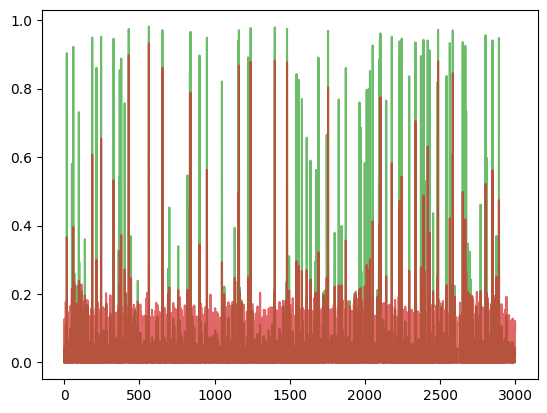

In [71]:
# plt.plot(res1.node_mask[0].cpu(), color='C0', alpha=0.7)
# plt.plot(res2.node_mask[9].cpu(), color='C1', alpha=0.7)
plt.plot(res3.node_mask[5].cpu(), color='C2', alpha=0.7)
plt.plot(res_cluster_model_250.node_mask[5].cpu(), color='C3', alpha=0.7)
# plt.plot(res4.node_mask[0].cpu(), color='C3', alpha=0.7)
# plt.plot(res5.node_mask[0].cpu(), color='C4', alpha=0.7)

print(torch.sort(res_cluster_model_250.node_mask[5], descending=True).indices.tolist()[:10])
plt.show()


[1401, 1482, 1240, 2397, 445, 911, 2487, 2233, 1162, 2569]


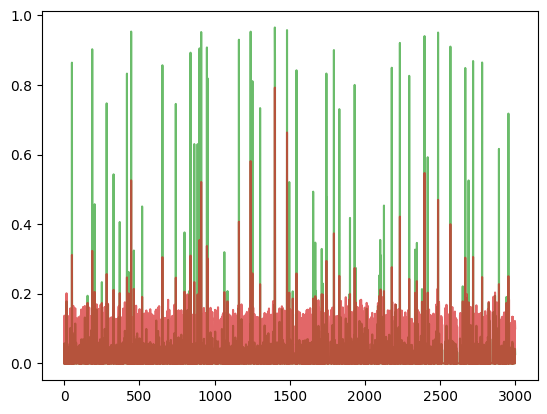

In [69]:
# plt.plot(res1.node_mask[0].cpu(), color='C0', alpha=0.7)
# plt.plot(res2.node_mask[9].cpu(), color='C1', alpha=0.7)
plt.plot(res3.node_mask[6].cpu(), color='C2', alpha=0.7)
plt.plot(res_cluster_model_250.node_mask[6].cpu(), color='C3', alpha=0.7)
# plt.plot(res4.node_mask[0].cpu(), color='C3', alpha=0.7)
# plt.plot(res5.node_mask[0].cpu(), color='C4', alpha=0.7)

print(torch.sort(res_cluster_model_250.node_mask[6], descending=True).indices.tolist()[:10])
plt.show()


tensor([3, 4, 1, 0, 0], device='cuda:0')


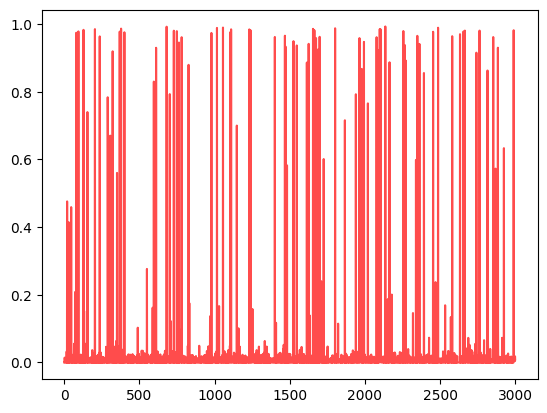

In [ ]:


print(clusters[[0,1,2,3,4]])

# plt.plot(res.node_mask[0].cpu(), color='blue', alpha=0.7)
# plt.plot(res.node_mask[3].cpu(), color='yellow', alpha=0.7)
plt.plot(res.node_mask[4].cpu(), color='red', alpha=0.7)

plt.show()

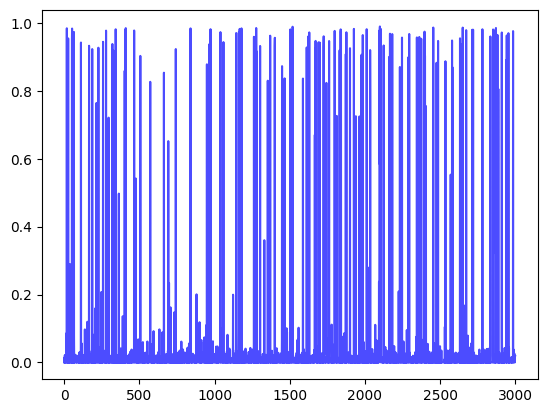

In [8]:
plt.plot(res.node_mask[0].cpu(), color='blue', alpha=0.7)
plt.show()

In [22]:
# plt.plot(res.node_mask[3].cpu(), color='yellow', alpha=0.7)
# plt.show()

res.node_mask[0][res.node_mask[0] > 0.96]


tensor([0.9843, 0.9836, 0.9736, 0.9774, 0.9814, 0.9796, 0.9848, 0.9778, 0.9840,
        0.9795, 0.9816, 0.9730, 0.9704, 0.9737, 0.9825, 0.9841, 0.9851, 0.9625,
        0.9810, 0.9889, 0.9846, 0.9602, 0.9722, 0.9606, 0.9766, 0.9811, 0.9757,
        0.9725, 0.9826, 0.9644, 0.9816, 0.9777, 0.9815, 0.9896, 0.9794, 0.9807,
        0.9823, 0.9683, 0.9673, 0.9675, 0.9744, 0.9865, 0.9863, 0.9788, 0.9800,
        0.9801, 0.9814, 0.9602, 0.9808, 0.9794, 0.9852, 0.9648, 0.9719, 0.9633,
        0.9699, 0.9760], device='cuda:0')